In [123]:
import pandas as pd

In [155]:
train_df = pd.read_csv('/content/train.csv')
test_df = pd.read_csv('/content/test.csv')

In [169]:
df = pd.read_csv(r'/content/sample_submission.csv')

In [171]:
df.head()

,id,price
0,54273,39218.443
1,54274,39218.443
2,54275,39218.443
3,54276,39218.443
4,54277,39218.443


In [165]:
train_df.shape

(54273, 16)

In [164]:
test_df.shape

(36183, 15)

In [156]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from datetime import datetime
import matplotlib.pyplot as plt



# Handle missing values
train_df.dropna(subset=['price'], inplace=True)

# Extract horsepower from the engine column
train_df['horsepower'] = train_df['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)
test_df['horsepower'] = test_df['engine'].str.extract(r'(\d+\.?\d*)HP').astype(float)

# Function to extract engine volume and number of cylinders
def extract_engine_details(engine_str):
    volume = re.search(r'(\d+\.\d+)L', engine_str)
    cylinders = re.search(r'(\d+)\sCylinder', engine_str)
    volume = float(volume.group(1)) if volume else np.nan
    cylinders = int(cylinders.group(1)) if cylinders else np.nan
    return volume, cylinders

# Apply the function to extract engine details
train_df[['engine_volume', 'cylinders']] = train_df['engine'].apply(lambda x: pd.Series(extract_engine_details(x)))
test_df[['engine_volume', 'cylinders']] = test_df['engine'].apply(lambda x: pd.Series(extract_engine_details(x)))

# Create a new feature: Age of the car
current_year = datetime.now().year
train_df['age'] = current_year - train_df['model_year']
test_df['age'] = current_year - test_df['model_year']

# Function to classify transmission types into broader categories
def classify_transmission(transmission):
    if 'Dual' in transmission or 'DCT' in transmission or 'Auto-Shift' in transmission:
        return 'Dual'
    elif 'A/T' in transmission or 'Automatic' in transmission:
        return 'Automatic'
    elif 'M/T' in transmission or 'Manual' in transmission:
        return 'Manual'
    else:
        return 'Other'

# Apply the function to classify transmissions
train_df['transmission_class'] = train_df['transmission'].apply(classify_transmission)
test_df['transmission_class'] = test_df['transmission'].apply(classify_transmission)

# Drop the original 'engine' and 'transmission' columns
train_df.drop(columns=['engine', 'transmission'], inplace=True)
test_df.drop(columns=['engine', 'transmission'], inplace=True)

# Define categorical and numerical columns
categorical_cols = ['brand', 'model', 'fuel_type', 'transmission_class', 'ext_col', 'int_col', 'accident', 'clean_title']
numerical_cols = ['milage', 'horsepower', 'engine_volume', 'cylinders', 'age']

# Preprocessing pipeline for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

# Preprocessing pipeline for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Define the target variable and features
X = train_df.drop(columns=['price', 'model_year', 'id'])
y = train_df['price']
testX = test_df.drop(columns=['model_year', 'id'])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and fit the preprocessing pipeline
preprocessor.fit(X_train)

preprocessor.fit(testX)

# Transform the data
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)
testX_processed = preprocessor.transform(testX)


In [157]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error

# Initialize the models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'xgb_model': XGBRegressor(random_state=42),

    'Gradient Boosting': GradientBoostingRegressor(random_state=42)
}

# Train and evaluate each model
model_performance = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train_processed, y_train)
    # Predict on the test set
    y_pred = model.predict(X_test_processed)
     # Calculate the Mean Absolute Error
    mae = mean_absolute_error(y_test, y_pred)
    # Calculate the Mean Squared Error
    mse = mean_squared_error(y_test, y_pred)
    # Calculate R-squared
    r2 = r2_score(y_test, y_pred)
    # Store the metrics
    model_performance[model_name] = {'MAE': mae, 'MSE': mse, 'R-squared': r2}



print(model_performance)


{'Linear Regression': {'MAE': 18249.382028684566, 'MSE': 2689387096.30686, 'R-squared': 0.08477571057958844}, 'Decision Tree': {'MAE': 22782.878734838014, 'MSE': 7394236644.602758, 'R-squared': -1.5163298314906344}, 'xgb_model': {'MAE': 16372.78105554216, 'MSE': 2567187337.447336, 'R-squared': 0.12636146356514244}, 'Gradient Boosting': {'MAE': 16544.114044905375, 'MSE': 2353442146.39187, 'R-squared': 0.1991010074074574}}


In [161]:
# Train the Random Forest model
random_forest = RandomForestRegressor(random_state=42, n_estimators=70, max_depth=10)  # Adjusted parameters  # Increase n_estimators and remove max_depth limit for better performance
random_forest.fit(X_train_processed, y_train)

# Predict on the test set
y_pred = random_forest.predict(X_test_processed)
actualpredictions = random_forest.predict(testX_processed)

# Calculate and print metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f'Random Forest MAE: {mae}')
print(f'Random Forest MSE: {mse}')
print(f'Random Forest R-squared: {r2}')


Random Forest MAE: 16798.995346281634
Random Forest MSE: 2589663097.190814
Random Forest R-squared: 0.11871274640253826


In [163]:
actualpredictions.shape

(36183,)

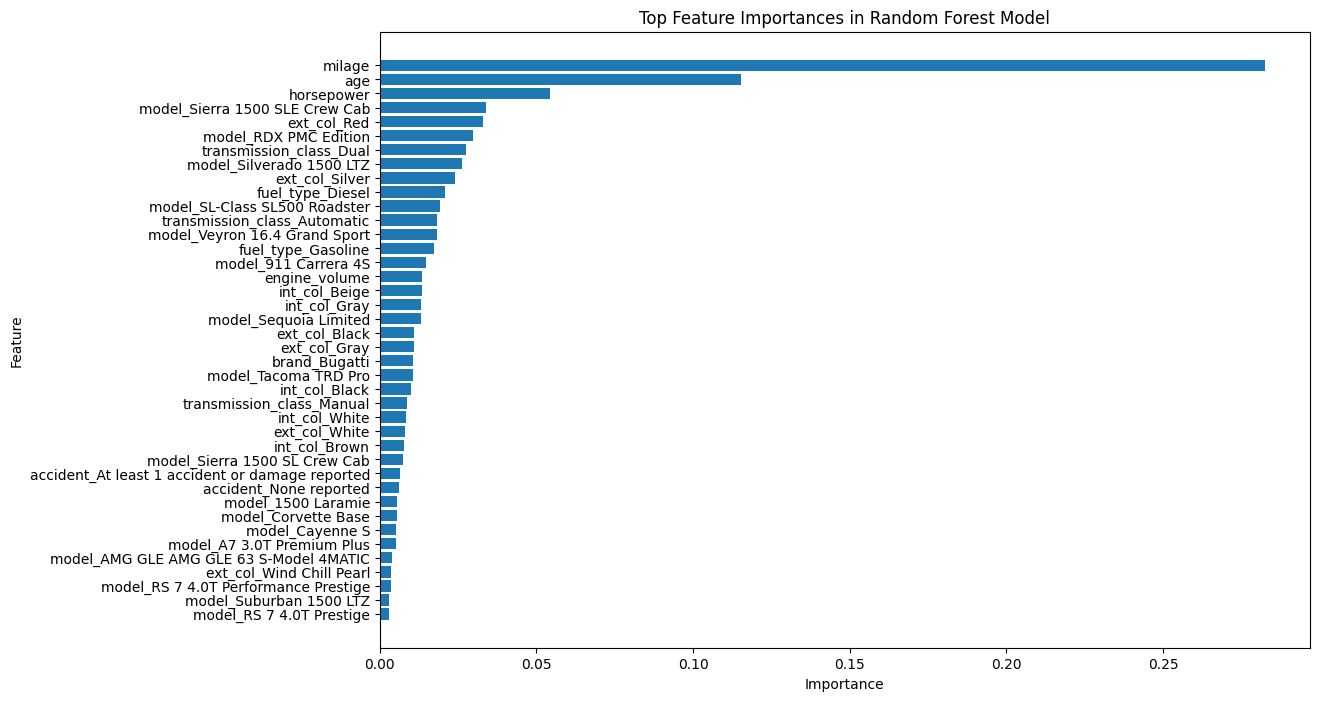

In [129]:

# Get feature importances
feature_importances = random_forest.feature_importances_

# Get feature names from the preprocessor
categorical_feature_names = preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols)
feature_names = np.concatenate((numerical_cols, categorical_feature_names))

# Create a DataFrame for feature importances
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

# Sort by importance and select the top N features
top_n = 40  # Number of top features to display
top_features_df = feature_importances_df.sort_values(by='Importance', ascending=False).head(top_n)

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(top_features_df['Feature'], top_features_df['Importance'])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top Feature Importances in Random Forest Model')
plt.gca().invert_yaxis()
plt.show()


In [119]:
#converting the test file

In [167]:
test_df.shape

(36183, 15)

In [168]:
actualpredictions = np.array(actualpredictions)

# Add the `actualpredictions` as a new column to `test_df`
test_df['predictions']

# Verify the new column has been added
print(test_df.head())

      id          brand                                              model  \
0  54273  Mercedes-Benz                                      E-Class E 350   
1  54274          Lexus                                        RX 350 Base   
2  54275  Mercedes-Benz                                      C-Class C 300   
3  54276           Land  Rover Range Rover 5.0L Supercharged Autobiogra...   
4  54277            BMW                                       X6 xDrive40i   

   model_year  milage fuel_type ext_col int_col  \
0        2014   73000  Gasoline   White   Beige   
1        2015  128032  Gasoline  Silver   Black   
2        2015   51983  Gasoline    Blue   White   
3        2018   29500  Gasoline   White   White   
4        2020   90000  Gasoline   White   Black   

                                 accident clean_title  horsepower  \
0                           None reported         Yes       302.0   
1                           None reported         Yes       275.0   
2                

In [172]:
test_df.columns

Index(['id', 'brand', 'model', 'model_year', 'milage', 'fuel_type', 'ext_col',
       'int_col', 'accident', 'clean_title', 'horsepower', 'engine_volume',
       'cylinders', 'age', 'transmission_class', 'predictions'],
      dtype='object')

In [173]:
# Keep only the 'id' and 'predictions' columns
test_df = test_df.loc[:, ['id', 'predictions']]

# Verify the remaining columns
print(test_df.head())


      id   predictions
0  54273  23316.057364
1  54274  17786.871587
2  54275  22825.477356
3  54276  75263.219224
4  54277  43088.119275


In [174]:
# Rename the 'predictions' column to 'price'
test_df = test_df.rename(columns={'predictions': 'price'})

# Verify the column name change
print(test_df.head())


      id         price
0  54273  23316.057364
1  54274  17786.871587
2  54275  22825.477356
3  54276  75263.219224
4  54277  43088.119275


In [175]:
test_df.to_csv('submission.csv', index=False)

In [176]:
test_df.shape

(36183, 2)

In [177]:
test_df.head()

,id,price
0,54273,23316.057364
1,54274,17786.871587
2,54275,22825.477356
3,54276,75263.219224
4,54277,43088.119275
